## PINN para a Equação do Calor 1D

Este notebook implementa uma **Rede Neural Informada pela Física (PINN)** para resolver a Equação do Calor 1D.

A abordagem combina o aprendizado supervisionado tradicional com a imposição de uma restrição física (a própria equação diferencial parcial), permitindo que a rede neural aprenda a solução do problema em todo o domínio espaço-tempo.

### A Equação do Calor 1D Transiente

A equação governante do fenômeno é:

$$ \frac{\partial T}{\partial t} = \alpha \frac{\partial^2 T}{\partial x^2} $$

Onde:
- $T$ é a temperatura.
- $t$ é o tempo.
- $x$ é a posição.
- $\alpha$ é a difusividade térmica do material (uma constante).

A rede neural será treinada para aproximar a função $T(x, t)$. A função de perda total será uma combinação de:

1.  **Perda de Dados (MSE):** O erro entre a previsão da rede e os dados de medição fornecidos.
2.  **Perda da Física (Residual da PDE):** Uma medida de quanto a saída da rede viola a equação do calor.

### Resumo do Procedimento

1.  **Carregar e Preparar Dados**: Carregue seu `df` e crie tensores para as posições `(x, t)` e temperaturas `T`.
2.  **Gerar Pontos de Colocação**: Crie um conjunto de pontos `(x, t)` aleatórios dentro do seu domínio para avaliar a perda da física.
3.  **Definir o Modelo**: Crie uma rede neural sequencial com Keras que mapeia `(x, t)` para `T`.
4.  **Implementar as Funções de Perda**:
    - `data_loss`: MSE entre as previsões e os dados reais.
    - `physics_loss`: MSE do residual da PDE, calculado usando `tf.GradientTape` para obter as derivadas.
5.  **Criar o Loop de Treinamento**:
    - Em cada época, calcule a perda de dados e a perda da física.
    - Some-as para obter a perda total.
    - Use `tf.GradientTape` para encontrar os gradientes da perda total em relação aos pesos do modelo.
    - Aplique esses gradientes usando um otimizador como o Adam.
6.  **Treinar e Avaliar**: Execute o loop por um número suficiente de épocas e, ao final, use o `pinn_model` treinado para fazer previsões e visualizar a solução.

### Importações

In [1]:
import os

os.environ["CUDA_VISIBLE_DEVICES"] = "0"
os.environ["KERAS_BACKEND"] = "tensorflow"

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
import tensorflow_probability as tfp

import time

from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

tf.random.set_seed(42)
np.random.seed(42)

print(f"TensorFlow Version: {tf.__version__}")

gpus = tf.config.list_physical_devices("GPU")
print(f"Número de GPUs disponíveis: {len(gpus)}")
if gpus:
    print("A GPU está sendo utilizada pelo TensorFlow.")
    print("Detalhes da GPU:", gpus)
else:
    print("O TensorFlow NÃO encontrou a GPU.")

2025-10-08 02:14:28.130792: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:31] Could not find cuda drivers on your machine, GPU will not be used.
2025-10-08 02:14:28.133681: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-10-08 02:14:28.247715: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2025-10-08 02:14:32.354017: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To tur

TensorFlow Version: 2.20.0
Número de GPUs disponíveis: 0
O TensorFlow NÃO encontrou a GPU.


E0000 00:00:1759900475.086112   10532 cuda_executor.cc:1309] INTERNAL: CUDA Runtime error: Failed call to cudaGetRuntimeVersion: Error loading CUDA libraries. GPU will not be used.: Error loading CUDA libraries. GPU will not be used.
W0000 00:00:1759900475.347456   10532 gpu_device.cc:2342] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly if you would like to use GPU. Follow the guide at https://www.tensorflow.org/install/gpu for how to download and setup the required libraries for your platform.
Skipping registering GPU devices...


### Leitura e Preparação dos Dados

Quantidade de pontos de treinamento 301.


(0.0, 1.0)

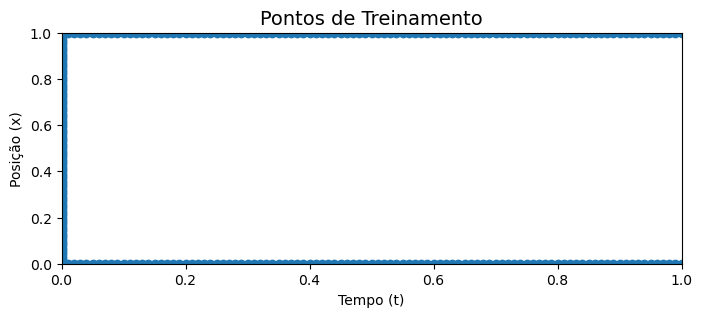

In [5]:
# Parâmetros do problema
ALPHA = 0.5

# Leitura dos dados
df_full = pd.read_csv("../../00-scientific_computer/data/problem1.csv")
df = df_full[
    (df_full["time"] == 0) | (df_full["position"] == 0) | (df_full["position"] == 1)
]
# df = df.sample(frac=0.665, random_state=42)
print(f"Quantidade de pontos de treinamento {len(df)}.")

# Dados completos, entrada (x, t) e saída (T)
X = df_full[["time", "position"]].values
T = df_full[["temperature"]].values

# Dados de treino
X_train_raw = df[["time", "position"]].values
T_train_raw = df[["temperature"]].values

# Converte para tensores do TensorFlow
X_train_tf = tf.convert_to_tensor(X_train_raw, dtype=tf.float32)
T_train_tf = tf.convert_to_tensor(T_train_raw, dtype=tf.float32)

# Plot
fig, ax = plt.subplots(figsize=(8, 3))

ax.scatter(X_train_raw[:, 0], X_train_raw[:, 1])

ax.set_title("Pontos de Treinamento", fontsize=14)
ax.set_xlabel("Tempo (t)", fontsize=10)
ax.set_ylabel("Posição (x)", fontsize=10)
ax.set_xlim([X[:, 0].min(), X[:, 0].max()])
ax.set_ylim([X[:, 1].min(), X[:, 1].max()])

### Normalização dos Dados

Os dados das entrada e saída já se encontram normalizado, estando nas faixas `[0, 1]` e `[-1, 1]` respectivamente. Buscando melhorar a estabilidade e a velocidade do treinamento.

### Geração dos Pontos de Colocação

Estes são os pontos no interior do domínio onde não conhecemos a temperatura. Eles serão usados para calcular a **perda da física** ($L_{física}$), forçando a rede a obedecer à equação do calor.

(0.0, 1.0)

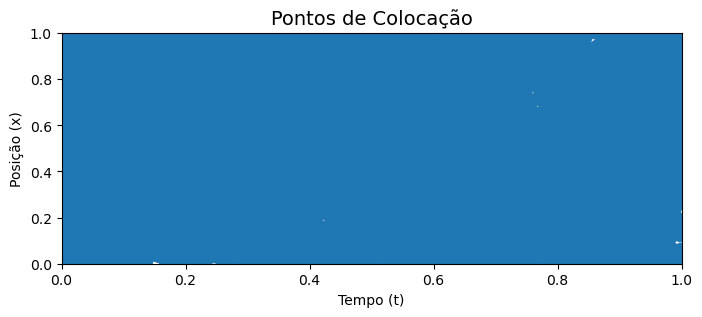

In [6]:
N_collocation = 20000

# Pega os limites do domínio a partir dos dados
t_min, t_max = df_full["time"].min(), df_full["time"].max()
x_min, x_max = df_full["position"].min(), df_full["position"].max()

# Gera pontos aleatórios dentro desses limites
x_collocation = tf.random.uniform(
    (N_collocation, 1), minval=x_min, maxval=x_max, dtype=tf.float32
)
t_collocation = tf.random.uniform(
    (N_collocation, 1), minval=t_min, maxval=t_max, dtype=tf.float32
)
X_collocation_raw = tf.concat([t_collocation, x_collocation], axis=1)
X_collocation_tf = tf.convert_to_tensor(X_collocation_raw, dtype=tf.float32)

# Plot
fig, ax = plt.subplots(figsize=(8, 3))

ax.scatter(X_collocation_raw[:, 0], X_collocation_raw[:, 1])

ax.set_title("Pontos de Colocação", fontsize=14)
ax.set_xlabel("Tempo (t)", fontsize=10)
ax.set_ylabel("Posição (x)", fontsize=10)
ax.set_xlim([t_min, t_max])
ax.set_ylim([x_min, x_max])

### Construção do Modelo (Rede Neural)

In [7]:
def create_pinn_model(num_hidden_layers=5, num_neurons=256):
    model = tf.keras.Sequential()

    model.add(tf.keras.layers.InputLayer(input_shape=(2,)))

    for _ in range(num_hidden_layers):
        model.add(tf.keras.layers.Dense(num_neurons, activation="tanh")) # tanh OR swish OR silu
        model.add(tf.keras.layers.Dropout(0.3))

    model.add(tf.keras.layers.Dense(1, activation="linear"))

    return model


pinn_model = create_pinn_model()
pinn_model.summary()

/home/thiag/GitHub/master-sciml/env/lib/python3.10/site-packages/keras/src/layers/core/input_layer.py:27: UserWarning: Argument `input_shape` is deprecated. Use `shape` instead.
  warnings.warn(


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense (Dense)                   │ (None, 256)            │           768 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 256)            │        65,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 256)            │        65,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 256)            │        65,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 256)            │        65,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 1)              │           257 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 264,193 (1.01 MB)

 Trainable params: 264,193 (1.01 MB)

 Non-trainable params: 0 (0.00 B)

### Função de Perda Híbrida

A função de perda total é a soma da perda nos dados e da perda na física. Aqui, implementamos o cálculo do resíduo da EDP.

In [8]:
def physics_loss(model, t, x):
    with tf.GradientTape(persistent=True) as tape:
        tape.watch(x)
        tape.watch(t)

        X_concat = tf.concat([t, x], axis=1)
        T_pred = model(X_concat)

        dT_dx = tape.gradient(T_pred, x)
        dT_dt = tape.gradient(T_pred, t)
        d2T_dx2 = tape.gradient(dT_dx, x)

    del tape

    # Resíduo da EDP
    residual = dT_dt - ALPHA * d2T_dx2

    return tf.reduce_mean(tf.square(residual))


def data_loss(model, X_data, T_data):
    T_pred = model(X_data)
    return tf.reduce_mean(tf.square(T_pred - T_data))

### Loop de Treinamento Customizado

Usamos um loop customizado para calcular as perdas e aplicar os gradientes a cada época.

In [9]:
optimizer = tf.keras.optimizers.Adam(learning_rate=1e-4)

W_DATA = 1.0
W_PHYSICS = 1.0


@tf.function
def train_step(model, X_data, T_data, X_collocation):
    with tf.GradientTape() as tape:
        loss_d = data_loss(model, X_data, T_data)
        loss_p = physics_loss(model, X_collocation[:, 0:1], X_collocation[:, 1:2])
        total_loss = W_DATA * loss_d + W_PHYSICS * loss_p

    gradients = tape.gradient(total_loss, model.trainable_variables)
    optimizer.apply_gradients(zip(gradients, model.trainable_variables))
    return loss_d, loss_p, total_loss


print("Iniciando Fase 1: Treinamento com Adam...")

EPOCHS_ADAM = 10000
start_time = time.time()
break_time = time.time()

for epoch in range(EPOCHS_ADAM):
    loss_d, loss_p, total_loss = train_step(
        pinn_model, X_train_tf, T_train_tf, X_collocation_tf
    )
    if (epoch + 1) % 500 == 0:
        print(
            f"Epoch {epoch+1:5d}, Time: {time.time() - break_time} s, Loss_Data: {loss_d:.4e}, Loss_Physics: {loss_p:.4e}, Loss_Total: {total_loss:.4e}"
        )
        break_time = time.time()
adam_time = time.time() - start_time

print(f"Fase 1 (Adam) concluída em {adam_time:.2f} segundos.")
print("\nIniciando Fase 2: Refinamento com L-BFGS...")


# Função auxiliar para definir os pesos a partir de um vetor 1D
def set_weights(model, weights_1d):
    """
    Desachata um vetor 1D de pesos e os atribui às variáveis do modelo.
    Esta função corrige a lógica de unflattening.
    """
    shapes = [v.shape for v in model.trainable_variables]
    sizes = [tf.reduce_prod(s) for s in shapes]

    start = 0
    for i, (shape, size) in enumerate(zip(shapes, sizes)):
        end = start + size
        # Pega a fatia do vetor 1D e remodela para a forma original da camada
        w = tf.reshape(weights_1d[start:end], shape)
        model.trainable_variables[i].assign(w)
        start = end


# Função de perda e gradientes que será passada para o otimizador L-BFGS
@tf.function
def loss_and_grads_func(weights_1d):
    """
    Calcula a perda e os gradientes para um dado vetor 1D de pesos.
    """
    # L-BFGS trabalha com float64, mas o modelo usa float32. Fazemos o cast temporário.
    set_weights(pinn_model, tf.cast(weights_1d, dtype=tf.float32))

    # Calcula a perda com os novos pesos
    with tf.GradientTape() as tape:
        loss_d = data_loss(pinn_model, X_train_tf, T_train_tf)
        loss_p = physics_loss(
            pinn_model, X_collocation_tf[:, 0:1], X_collocation_tf[:, 1:2]
        )
        total_loss = loss_d + loss_p

    # Calcula os gradientes (eles serão float32)
    grads = tape.gradient(total_loss, pinn_model.trainable_variables)

    # Achata a lista de gradientes em um único vetor 1D
    grads_1d = tf.concat([tf.reshape(g, [-1]) for g in grads], axis=0)

    # Para estabilidade numérica, retorna a perda e os gradientes como float64
    return tf.cast(total_loss, tf.float64), tf.cast(grads_1d, tf.float64)


# Execução da otimização L-BFGS

# Pega os pesos atuais do modelo (após Adam) e os achata em um vetor 1D
initial_weights = tf.concat(
    [tf.reshape(v, [-1]) for v in pinn_model.trainable_variables], axis=0
)

start_time = time.time()
# Chama o otimizador L-BFGS
# Nota: O L-BFGS não imprime o progresso por padrão. O cálculo da perda é feito dentro da função.
results = tfp.optimizer.lbfgs_minimize(
    value_and_gradients_function=loss_and_grads_func,
    initial_position=tf.cast(
        initial_weights, tf.float64
    ),  # Importante: passar pesos como float64
    num_correction_pairs=100,
    max_iterations=20000,
    tolerance=1e-10,
)
lbfgs_time = time.time() - start_time
print(f"Fase 2 (L-BFGS) concluída em {lbfgs_time:.2f} segundos.")


# Atribuição final dos pesos otimizados
# `results.position` contém o vetor 1D de pesos otimizados (em float64)
optimized_weights_1d = results.position
set_weights(pinn_model, tf.cast(optimized_weights_1d, dtype=tf.float32))

# Imprime a perda final após L-BFGS
final_loss_d = data_loss(pinn_model, X_train_tf, T_train_tf)
final_loss_p = physics_loss(
    pinn_model, X_collocation_tf[:, 0:1], X_collocation_tf[:, 1:2]
)
final_total_loss = final_loss_d + final_loss_p

print("\nTreinamento concluído.")
print(
    f"Perda Final (após L-BFGS): Loss_Data: {final_loss_d:.4e}, Loss_Physics: {final_loss_p:.4e}, Loss_Total: {final_total_loss:.4e}"
)

Iniciando Fase 1: Treinamento com Adam...


KeyboardInterrupt: 

### Métricas de Avaliação

Agora, usamos o modelo treinado para prever a temperatura em todo o domínio e comparamos com os dados de treinamento originais.

In [ ]:
# Fazer previsões nos mesmos pontos do DataFrame de treinamento
T_pred = pinn_model.predict(X)

# Calcular as métricas de erro
mse = mean_squared_error(T, T_pred)
mae = mean_absolute_error(T, T_pred)
r2 = r2_score(T, T_pred)

print(f"Erro Quadrático Médio (MSE): {mse:.6f}")
print(f"Erro Absoluto Médio (MAE):  {mae:.6f}")
print(f"R2 Score:  {r2:.6f}")

### Visualização dos Resultados

In [ ]:
# Perfis de Temperatura ao Longo do Tempo

t = np.unique(X[:, 0])
x = np.unique(X[:, 1])

Nt = len(t)
Nx = len(x)

U_sol = T.reshape([Nt, Nx])
U_pred = T_pred.reshape([Nt, Nx])
Err = U_sol - U_pred

fig, ax = plt.subplots(figsize=(8, 3))

idx_time = [0, Nt // 4, Nt // 2, 3 * Nt // 4, Nt - 1]  # Pega 5 instantes de tempo
for i, t_idx in enumerate(idx_time):
    line = ax.plot(x, U_sol[t_idx, :], label=f"t = {t[t_idx]:.2f} s (true)")[0]
    plot_color = line.get_color()
    ax.plot(x, U_pred[t_idx, :], "x", color=plot_color, label=f"t = {t[t_idx]:.2f} s (pred)")

ax.set_title("Evolução do Perfil de Temperatura", fontsize=14)
ax.set_xlabel("Posição (x)", fontsize=10)
ax.set_ylabel("Temperatura (U)", fontsize=10)
ax.legend()

ax.spines["top"].set_visible(False)
ax.spines["right"].set_visible(False)

In [ ]:
# Mapa de Calor U(x, t) - Valores Reais

fig, ax = plt.subplots(1,3, figsize=(25, 3))

# Meshgrid para as coordenadas. Note que pcolormesh usa as coordenadas dos cantos.
T_grid, X_grid = np.meshgrid(t, x)

# A matriz de cores (U_sol.T) deve ter dimensões (Nx, Nt)
# Usamos shading='gouraud' para interpolação suave de cores.
im = ax[0].pcolormesh(T_grid, X_grid, U_sol.T, cmap="coolwarm", shading="gouraud")

# Adiciona a barra de cores
cbar = fig.colorbar(im, ax=ax[0])
cbar.set_label("Temperatura (U)", fontsize=10)

ax[0].set_title("Solução U(x, t)")
ax[0].set_xlabel("Tempo (t)", fontsize=10)
ax[0].set_ylabel("Posição (x)", fontsize=10)

ax[0].spines["top"].set_visible(False)
ax[0].spines["right"].set_visible(False)

# Mapa de Calor U(x, t) - Valores Previstos

# fig, ax = plt.subplots(figsize=(8, 3))
im = ax[1].pcolormesh(T_grid, X_grid, U_pred.T, cmap="coolwarm", shading="gouraud")
cbar = fig.colorbar(im, ax=ax[1])
cbar.set_label("Temperatura (U)", fontsize=10)

ax[1].set_title("Predição U(x, t)")
ax[1].set_xlabel("Tempo (t)", fontsize=10)
ax[1].set_ylabel("Posição (x)", fontsize=10)

ax[1].spines["top"].set_visible(False)
ax[1].spines["right"].set_visible(False)

# Mapa de Calor do Erro Err(x, t)

# fig, ax = plt.subplots(figsize=(8, 3))
im = ax[2].pcolormesh(T_grid, X_grid, Err.T, cmap="hot", shading="gouraud")
cbar = fig.colorbar(im, ax=ax[2])
cbar.set_label("Erro", fontsize=10)

ax[2].set_title("Erro de Predição")
ax[2].set_xlabel("Tempo (t)", fontsize=10)
ax[2].set_ylabel("Posição (x)", fontsize=10)

ax[2].spines["top"].set_visible(False)
ax[2].spines["right"].set_visible(False)